**Updated**: 08.08.2021

In [1]:
import numpy as np
import sqlite3 as sq
import matplotlib.pyplot as plt
import matplotlib.collections
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import json
import matplotlib.text as mtext
from colors import Colors
import seaborn as sns

%matplotlib inline
# green mean, yellow median

In [2]:
connection = sq.connect("./performance-measurements/merged-new.db")
connection.row_factory = sq.Row

In [3]:
vantage_points = {
                  'US East':                  {'short': 'us-east_'},
                  'Asia Pacific Northeast':   {'short': 'ap-northeast_'},
                  'Africa South':             {'short': 'af-south_'},
                  'Europe Central':           {'short': 'eu-central_'},
                  'Asia Pacific Southeast':   {'short': 'ap-southeast_'},
                  'US West':                  {'short': 'us-west_'},
                  'South America East':       {'short': 'sa-east_'},
                  'All':                      {'short': ''}
                 }

In [4]:
def average(items, key):
    total = 0
    for item in items:
        try:
            total += item[key]
        except:
            pass
    return total/len(items)

def getTraceroutesForProtocol(protocol):
    def generateStatement(protocol):
        return "SELECT ip FROM dns_measurements {} WHERE {}.protocol = '{}' AND {}.response_ip IS NOT NULL AND NOT {}.cache_warming".format(protocol, protocol, protocol, protocol, protocol)
    statements = {
        "udp": generateStatement("udp"),
        "tcp": generateStatement("tcp"),
        "tls": generateStatement("tls"),
        "https": generateStatement("https"),
        "quic": generateStatement("quic")
    }
    del statements[protocol]
    sql = """
    SELECT * from traceroutes WHERE (dns_measurement_id, hop_ip, dest_port, protocol) IN (SELECT id, ip, port, protocol FROM dns_measurements measurement
    WHERE measurement.protocol = '{}' AND measurement.r_code IS NOT NULL AND measurement.total_time IS NOT NULL AND measurement.total_time <= 5000000000
      AND NOT measurement.cache_warming
      AND measurement.ip IN ({})
      AND measurement.ip IN ({})
      AND measurement.ip IN ({})
      AND measurement.ip IN ({}));
    """.format(protocol, *statements.values())
    df = pd.read_sql_query(sql, connection)
    return df

def getTraceroutesForProtocolPairwise(protocol):
    def generateStatement(protocol):
        return "SELECT ip FROM dns_measurements {} WHERE {}.protocol = '{}' AND {}.response_ip IS NOT NULL AND NOT {}.cache_warming".format(protocol, protocol, protocol, protocol, protocol)
    statements = {
        "udp": generateStatement("udp"),
        "tcp": generateStatement("tcp"),
        "tls": generateStatement("tls"),
        "https": generateStatement("https"),
        "quic": generateStatement("quic")
    }
    del statements[protocol]
    sql = """
    SELECT * from traceroutes WHERE (dns_measurement_id, hop_ip, dest_port, protocol) IN (SELECT id, ip, port, protocol FROM dns_measurements measurement
    WHERE measurement.protocol = '{}' AND measurement.r_code IS NOT NULL AND measurement.total_time IS NOT NULL AND measurement.total_time <= 5000000000
      AND NOT measurement.cache_warming
      AND measurement.ip IN ({})
      AND measurement.ip IN ({})
      AND measurement.ip IN ({})
      AND measurement.ip IN ({})) 
      AND hop_ip IN (SELECT DISTINCT(hop_ip) FROM traceroutes WHERE protocol = 'udp' AND hop_ip = dest_ip)
      AND hop_ip IN (SELECT DISTINCT(hop_ip) FROM traceroutes WHERE protocol = 'quic' AND hop_ip = dest_ip)
      AND hop_ip IN (SELECT DISTINCT(hop_ip) FROM traceroutes WHERE protocol = 'tcp' AND hop_ip = dest_ip)
      AND hop_ip IN (SELECT DISTINCT(hop_ip) FROM traceroutes WHERE protocol = 'tls' AND hop_ip = dest_ip)
      AND hop_ip IN (SELECT DISTINCT(hop_ip) FROM traceroutes WHERE protocol = 'https' AND hop_ip = dest_ip);
    """.format(protocol, *statements.values())
    df = pd.read_sql_query(sql, connection)
    return df

def getMeanTraceroutesPairwise():
    udp = getTraceroutesForProtocolPairwise("udp")["rtt"].div(1000000)
    tcp = getTraceroutesForProtocolPairwise("tcp")["rtt"].div(1000000)
    tls = getTraceroutesForProtocolPairwise("tls")["rtt"].div(1000000)
    https = getTraceroutesForProtocolPairwise("https")["rtt"].div(1000000)
    quic = getTraceroutesForProtocolPairwise("quic")["rtt"].div(1000000)
    
    fig = plt.figure(figsize = (10, 7))
    ax = fig.add_subplot(111)
    bp = ax.boxplot([udp.values.tolist(), tcp.values.tolist(), tls.values.tolist(), https.values.tolist(), quic.values.tolist()], vert = 0, showfliers = False)

    ax.set_yticklabels(["UDP", "TCP", "TLS", "HTTPS", "QUIC"])

    ax.set_xlabel("ms", fontsize = 12)
    ax.set_ylabel("Protocol", fontsize = 12)
    plt.title("RTT for Hosts with all Protocols Reachable")

    plt.show(bp)
    
    df = pd.DataFrame({ 
        "Protocol": ["UDP", "TCP", "TLS", "HTTPS", "QUIC"],
        "Samples": [len(udp), len(tcp), len(tls), len(https), len(quic)]
    })
    print(df.to_markdown())
    
def getMeanTraceroutes():
    udp_df = getTraceroutesForProtocolPairwise("udp")
    udp_df["rtt"] = udp_df["rtt"].div(1000000)
    tcp_df = getTraceroutesForProtocolPairwise("tcp")
    tcp_df["rtt"] = tcp_df["rtt"].div(1000000)
    tls_df = getTraceroutesForProtocolPairwise("tls")
    tls_df["rtt"] = tls_df["rtt"].div(1000000)
    https_df = getTraceroutesForProtocolPairwise("https")
    https_df["rtt"] = https_df["rtt"].div(1000000)
    quic_df = getTraceroutesForProtocolPairwise("quic")
    quic_df["rtt"] = quic_df["rtt"].div(1000000)
    
    udp = udp_df.groupby("dest_ip")["rtt"].median().reset_index()["rtt"]
    tcp = tcp_df.groupby("dest_ip")["rtt"].median().reset_index()["rtt"]
    tls = tls_df.groupby("dest_ip")["rtt"].median().reset_index()["rtt"]
    https = https_df.groupby("dest_ip")["rtt"].median().reset_index()["rtt"]
    quic = quic_df.groupby("dest_ip")["rtt"].median().reset_index()["rtt"]
    
    fig = plt.figure(figsize = (10, 7))
    ax = fig.add_subplot(111)
    bp = ax.boxplot([udp.values.tolist(), tcp.values.tolist(), tls.values.tolist(), https.values.tolist(), quic.values.tolist()], vert = 0, sym = "", patch_artist=True, meanline = True, showmeans = True)
    setBoxesWhite(bp)

    for median in bp["medians"]:
        x, y = median.get_data()
        ax.text(x[0] - 4, y[0] - 0.2, "{:.0f}".format(x[0]), fontsize = 9, color='black')

    ax.set_yticklabels(["UDP", "TCP", "TLS", "HTTPS", "QUIC"])

    ax.set_xlabel("ms", fontsize = 12)
    ax.set_ylabel("Protocol", fontsize = 12)
    plt.grid()
    
    plt.savefig("figures/median_traceroutes_boxplot.pdf", bbox_inches='tight')
    plt.show(bp)
    
def getQUICMedianTraceroutes(cacheWarming = False, protocol = "quic"):
    cacheCondition = "AND NOT d.cache_warming" if not cacheWarming else "AND d.cache_warming"
    sql = """
    SELECT
       d.id, d.ip, d.port, d.protocol, d.q_ui_c_handshake_duration as quic_handshake_duration, d.query_time, d.tcp_handshake_duration, d.tls_handshake_duration, d.total_time, d.q_ui_c_version
    FROM dns_measurements d
    WHERE d.protocol = '{}' {}
    AND d.id IN (SELECT DISTINCT(t.dns_measurement_id) FROM traceroutes t where t.dest_ip = t.hop_ip AND t.protocol = '{}');
    """.format(protocol, cacheCondition, protocol)
    handshake_duration = pd.read_sql_query(sql, connection)
    sql = """
    SELECT
    t.dns_measurement_id as id, dest_port as port, protocol, dest_ip, hop_ip, rtt
    FROM traceroutes t
    WHERE t.protocol = '{}' AND t.dest_ip = t.hop_ip
    """.format(protocol)
    rtts = pd.read_sql_query(sql, connection).groupby("id").sample(n = 1)
    return pd.merge(handshake_duration, rtts, on = ["id", "protocol", "port"])

def getQUICMedianResolveTime(vp=''):
    sql = f"""
    SELECT ip, query_time FROM dns_measurements measurement
    WHERE measurement.protocol = 'quic' AND measurement.r_code IS NOT NULL AND measurement.total_time IS NOT NULL AND measurement.total_time <= 5000000000
      AND measurement.id LIKE '{vp}%'
      AND NOT measurement.cache_warming
      AND measurement.ip IN (SELECT ip FROM dns_measurements udp WHERE udp.protocol = 'udp' AND udp.response_ip IS NOT NULL AND NOT udp.cache_warming)
      AND measurement.ip IN (SELECT ip FROM dns_measurements tcp WHERE tcp.protocol = 'tcp' AND tcp.response_ip IS NOT NULL AND NOT tcp.cache_warming)
      AND measurement.ip IN (SELECT ip FROM dns_measurements tls WHERE tls.protocol = 'tls' AND tls.response_ip IS NOT NULL AND NOT tls.cache_warming)
      AND measurement.ip IN (SELECT ip FROM dns_measurements https WHERE https.protocol = 'https' AND https.response_ip IS NOT NULL AND NOT https.cache_warming);
    """
    quic_df = pd.read_sql_query(sql, connection)
    quic_df["query_time"] = quic_df["query_time"].div(1000000)
    
    quic = quic_df.groupby("ip")["query_time"].median().reset_index()
    return quic

def getUDP(vp=''):
    sql = f"""
    SELECT * FROM dns_measurements measurement
    WHERE measurement.protocol = 'udp' AND measurement.r_code IS NOT NULL AND measurement.total_time IS NOT NULL AND measurement.total_time <= 5000000000
      AND measurement.id LIKE '{vp}%'
      AND NOT measurement.cache_warming
      AND measurement.ip IN (SELECT ip FROM dns_measurements tcp WHERE tcp.protocol = 'tcp' AND tcp.response_ip IS NOT NULL AND NOT tcp.cache_warming)
      AND measurement.ip IN (SELECT ip FROM dns_measurements tls WHERE tls.protocol = 'tls' AND tls.response_ip IS NOT NULL AND NOT tls.cache_warming)
      AND measurement.ip IN (SELECT ip FROM dns_measurements https WHERE https.protocol = 'https' AND https.response_ip IS NOT NULL AND NOT https.cache_warming)
      AND measurement.ip IN (SELECT ip FROM dns_measurements quic WHERE quic.protocol = 'quic' AND quic.response_ip IS NOT NULL AND NOT quic.cache_warming);
    """
    cursor = connection.cursor()
    cursor.execute(sql)
    items = list(cursor.fetchall())
    cursor.close()
    return items

def getTCP(vp=''):
    sql = f"""
    SELECT * FROM dns_measurements measurement
    WHERE measurement.protocol = 'tcp' AND measurement.r_code IS NOT NULL AND measurement.total_time IS NOT NULL AND measurement.total_time <= 5000000000
      AND measurement.id LIKE '{vp}%'
      AND NOT measurement.cache_warming
      AND measurement.ip IN (SELECT ip FROM dns_measurements udp WHERE udp.protocol = 'udp' AND udp.response_ip IS NOT NULL AND NOT udp.cache_warming)
      AND measurement.ip IN (SELECT ip FROM dns_measurements tls WHERE tls.protocol = 'tls' AND tls.response_ip IS NOT NULL AND NOT tls.cache_warming)
      AND measurement.ip IN (SELECT ip FROM dns_measurements https WHERE https.protocol = 'https' AND https.response_ip IS NOT NULL AND NOT https.cache_warming)
      AND measurement.ip IN (SELECT ip FROM dns_measurements quic WHERE quic.protocol = 'quic' AND quic.response_ip IS NOT NULL AND NOT quic.cache_warming);
    """
    cursor = connection.cursor()
    cursor.execute(sql)
    items = list(cursor.fetchall())
    cursor.close()
    return items

def getTLS(vp=''):
    sql = f"""
    SELECT * FROM dns_measurements measurement
    WHERE measurement.protocol = 'tls' AND measurement.r_code IS NOT NULL AND measurement.total_time IS NOT NULL AND measurement.total_time <= 5000000000
      AND measurement.id LIKE '{vp}%'
      AND NOT measurement.cache_warming
      AND measurement.ip IN (SELECT ip FROM dns_measurements udp WHERE udp.protocol = 'udp' AND udp.response_ip IS NOT NULL AND NOT udp.cache_warming)
      AND measurement.ip IN (SELECT ip FROM dns_measurements tcp WHERE tcp.protocol = 'tcp' AND tcp.response_ip IS NOT NULL AND NOT tcp.cache_warming)
      AND measurement.ip IN (SELECT ip FROM dns_measurements https WHERE https.protocol = 'https' AND https.response_ip IS NOT NULL AND NOT https.cache_warming)
      AND measurement.ip IN (SELECT ip FROM dns_measurements quic WHERE quic.protocol = 'quic' AND quic.response_ip IS NOT NULL AND NOT quic.cache_warming);
    """
    cursor = connection.cursor()
    cursor.execute(sql)
    items = list(cursor.fetchall())
    cursor.close()
    return items

def getHTTPS(vp=''):
    sql = f"""
    SELECT * FROM dns_measurements measurement
    WHERE measurement.protocol = 'https' AND measurement.r_code IS NOT NULL AND measurement.total_time IS NOT NULL AND measurement.total_time <= 5000000000
      AND measurement.id LIKE '{vp}%'
      AND NOT measurement.cache_warming
      AND measurement.ip IN (SELECT ip FROM dns_measurements udp WHERE udp.protocol = 'udp' AND udp.response_ip IS NOT NULL AND NOT udp.cache_warming)
      AND measurement.ip IN (SELECT ip FROM dns_measurements tcp WHERE tcp.protocol = 'tcp' AND tcp.response_ip IS NOT NULL AND NOT tcp.cache_warming)
      AND measurement.ip IN (SELECT ip FROM dns_measurements tls WHERE tls.protocol = 'tls' AND tls.response_ip IS NOT NULL AND NOT tls.cache_warming)
      AND measurement.ip IN (SELECT ip FROM dns_measurements quic WHERE quic.protocol = 'quic' AND quic.response_ip IS NOT NULL AND NOT quic.cache_warming);
    """
    cursor = connection.cursor()
    cursor.execute(sql)
    items = list(cursor.fetchall())
    cursor.close()
    return items

def getQUIC(vp=''):
    sql = f"""
    SELECT * FROM dns_measurements measurement
    WHERE measurement.protocol = 'quic' AND measurement.r_code IS NOT NULL AND measurement.total_time IS NOT NULL AND measurement.total_time <= 5000000000
      AND measurement.id LIKE '{vp}%'
      AND NOT measurement.cache_warming
      AND measurement.ip IN (SELECT ip FROM dns_measurements udp WHERE udp.protocol = 'udp' AND udp.response_ip IS NOT NULL AND NOT udp.cache_warming)
      AND measurement.ip IN (SELECT ip FROM dns_measurements tcp WHERE tcp.protocol = 'tcp' AND tcp.response_ip IS NOT NULL AND NOT tcp.cache_warming)
      AND measurement.ip IN (SELECT ip FROM dns_measurements tls WHERE tls.protocol = 'tls' AND tls.response_ip IS NOT NULL AND NOT tls.cache_warming)
      AND measurement.ip IN (SELECT ip FROM dns_measurements https WHERE https.protocol = 'https' AND https.response_ip IS NOT NULL AND NOT https.cache_warming);
    """
    cursor = connection.cursor()
    cursor.execute(sql)
    items = list(cursor.fetchall())
    cursor.close()
    return items

def getQUICNegotiatedProtocol(vp=''):
    sql = f"""
    SELECT DISTINCT(measurement.ip), measurement.q_ui_c_negotiated_protocol FROM dns_measurements measurement
    WHERE measurement.protocol = 'quic' AND measurement.r_code IS NOT NULL
    AND NOT measurement.cache_warming
    AND measurement.id LIKE '{vp}%';
    """
    cursor = connection.cursor()
    cursor.execute(sql)
    items = list(cursor.fetchall())
    cursor.close()
    return items

def getQUICVersions(vp=''):
    sql = f"""
    SELECT DISTINCT(measurement.ip), measurement.q_ui_c_version FROM dns_measurements measurement
    WHERE measurement.protocol = 'quic' AND measurement.r_code IS NOT NULL
    AND NOT measurement.cache_warming
    AND measurement.id LIKE '{vp}%';
    """
    cursor = connection.cursor()
    cursor.execute(sql)
    items = list(cursor.fetchall())
    cursor.close()
    return items

def getNumberOfSamples(vp=''):
    udp = len(getUDP(vp))
    tcp = len(getTCP(vp))
    tls = len(getTLS(vp))
    https = len(getHTTPS(vp))
    quic = len(getQUIC(vp))
    return pd.DataFrame({ 
        "Protocol": ["UDP", "TCP", "TLS", "HTTPS", "QUIC"],
        "Samples": [udp, tcp, tls, https, quic]
    })

def getData(vp=''):
    udp = getUDP(vp)
    tcp = getTCP(vp)
    tls = getTLS(vp)
    https = getHTTPS(vp)
    quic = getQUIC(vp)
    return pd.DataFrame(udp + tcp + tls + https + quic, columns = udp[0].keys())

def calculateCDF(items):
    count, bins_count = np.histogram(items, bins="auto")

    pdf = count / sum(count)

    # using numpy np.cumsum to calculate the CDF
    # We can also find using the PDF values by looping and adding
    cdf = np.cumsum(pdf)
    return bins_count[1:], cdf

def setBoxesWhite(bp):
    for patch in bp['boxes']:
        patch.set_facecolor("white")

### Total Servers used

In [5]:
for key, vp in vantage_points.items():
    print(key)
    vp['allData'] = getData(vp['short'])
    print(len(vp['allData']["ip"].unique()))

US East
199
Asia Pacific Northeast
199
Africa South
144
Europe Central
200
Asia Pacific Southeast
199
US West
199
South America East
199
All
200


In [6]:
for key, vp in vantage_points.items():
    vp['UDP'] = getUDP(vp['short'])
    vp['TCP'] = getTCP(vp['short'])
    vp['TLS'] = getTLS(vp['short'])
    vp['HTTPS'] = getHTTPS(vp['short'])
    vp['QUIC'] = getQUIC(vp['short'])

### Average Total Times

In [7]:
for key, vp in vantage_points.items():
    vp['average_total_time'] = {
        'UDP': average(vp['UDP'], "total_time") / 1000000,
        'TCP': average(vp['TCP'], "total_time") / 1000000,
        'TLS': average(vp['TLS'], "total_time") / 1000000,
        'HTTPS': average(vp['HTTPS'], "total_time") / 1000000,
        'QUIC': average(vp['QUIC'], "total_time") / 1000000
    }

In [8]:
row_labels = [key for key in vantage_points]
col_labels = ['UDP', 'TCP', 'TLS', 'HTTPS', 'QUIC']
total_times = [[vp['average_total_time'][protocol] for protocol in col_labels] for key, vp in vantage_points.items()]
total_times_df = pd.DataFrame(total_times, columns=col_labels, index=row_labels)
total_times_df.style.background_gradient(cmap='RdYlGn_r')

,UDP,TCP,TLS,HTTPS,QUIC
US East,124.513976,261.619850,393.126737,395.542939,445.105205
Asia Pacific Northeast,168.990706,333.581587,523.103042,511.692151,599.375721
Africa South,257.716484,521.778059,785.963477,771.677670,872.257137
Europe Central,115.393041,233.288071,354.011803,345.082152,380.228759
Asia Pacific Southeast,212.620732,425.100899,647.405272,644.610164,743.046436
US West,137.791927,282.048207,423.825843,426.220988,497.940746
South America East,239.367537,474.379484,719.916195,717.567116,805.561602
All,183.684902,369.233309,560.905217,555.517390,632.898526


In [9]:
total_times_df.style.background_gradient(cmap='RdYlGn_r', axis=1)

,UDP,TCP,TLS,HTTPS,QUIC
US East,124.513976,261.619850,393.126737,395.542939,445.105205
Asia Pacific Northeast,168.990706,333.581587,523.103042,511.692151,599.375721
Africa South,257.716484,521.778059,785.963477,771.677670,872.257137
Europe Central,115.393041,233.288071,354.011803,345.082152,380.228759
Asia Pacific Southeast,212.620732,425.100899,647.405272,644.610164,743.046436
US West,137.791927,282.048207,423.825843,426.220988,497.940746
South America East,239.367537,474.379484,719.916195,717.567116,805.561602
All,183.684902,369.233309,560.905217,555.517390,632.898526


<AxesSubplot:>

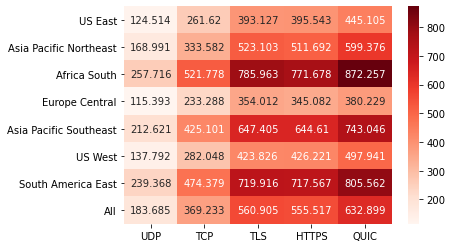

In [13]:
sns.heatmap(total_times_df, annot=True, fmt='g', cmap='Reds')

#### Number of Samples

In [14]:
for key, vp in vantage_points.items():
    vp['number_of_samples'] = getNumberOfSamples(vp['short']).set_index("Protocol")
total_samples = [[vp['number_of_samples'].loc[protocol]['Samples'] for protocol in col_labels] for key, vp in vantage_points.items()]
total_samples_df = pd.DataFrame(total_samples, columns=col_labels, index=row_labels)
total_samples_df

,UDP,TCP,TLS,HTTPS,QUIC
US East,376,389,389,388,421
Asia Pacific Northeast,388,392,389,390,420
Africa South,411,413,411,404,441
Europe Central,411,409,410,405,439
Asia Pacific Southeast,385,385,385,384,421
US West,384,387,386,383,421
South America East,576,577,578,570,631
All,2931,2952,2948,2924,3194


### Comparing Protocols

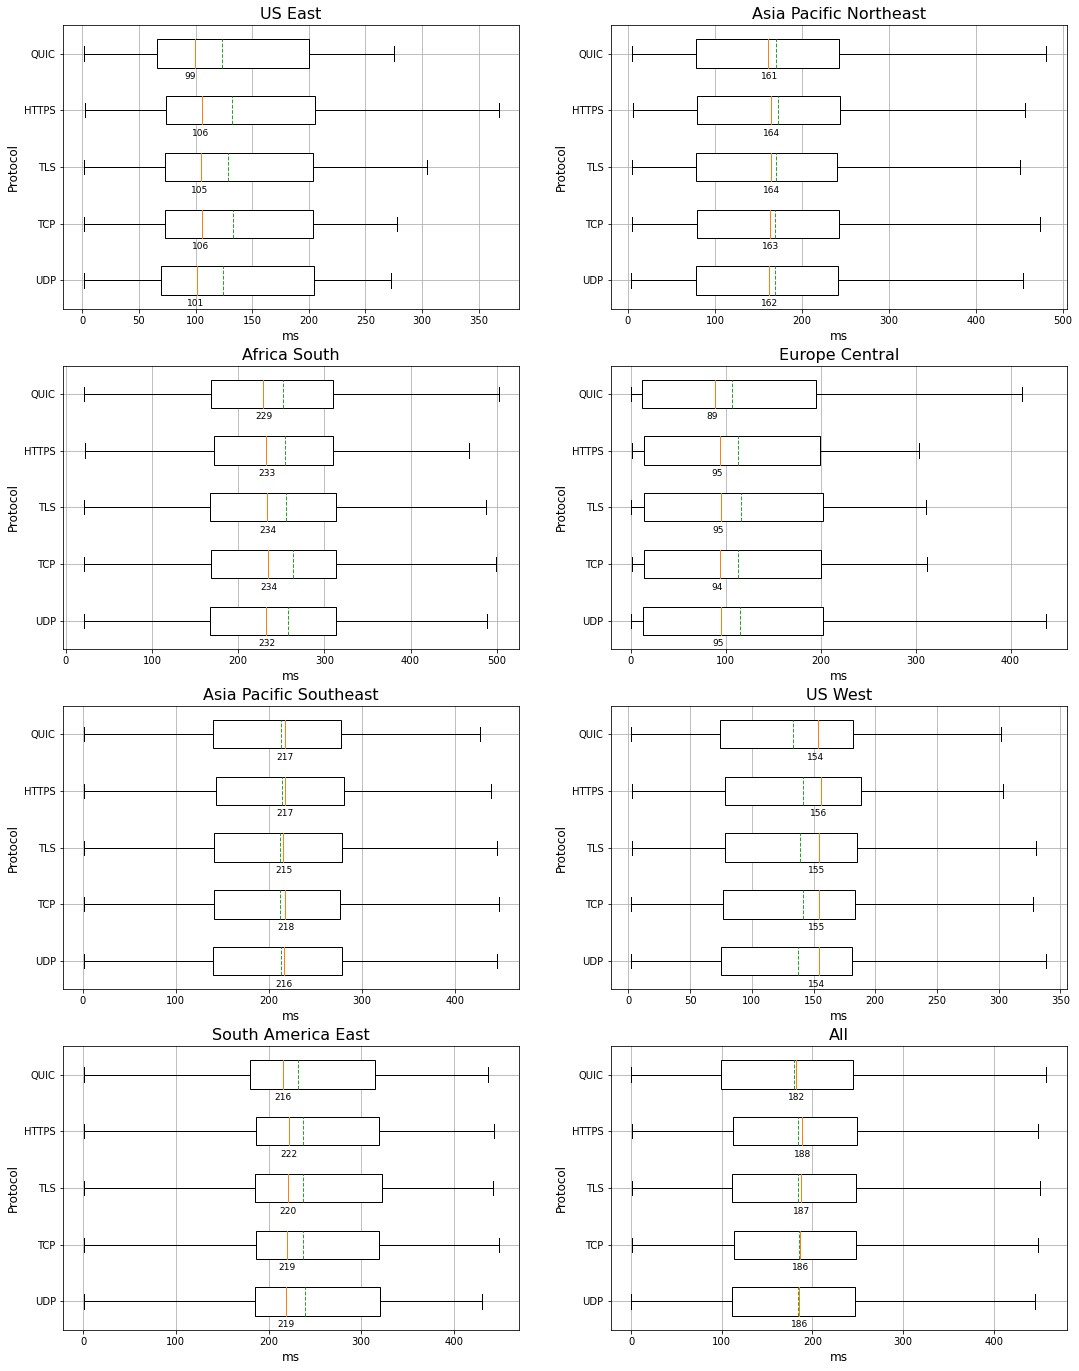

In [15]:
for key, vp in vantage_points.items():
    vp['query_time'] = {
    'UDP': list(map(lambda x: x["query_time"] / 1000000, vp['UDP'])),
    'TCP': list(map(lambda x: x["query_time"] / 1000000, vp['TCP'])),
    'TLS': list(map(lambda x: x["query_time"] / 1000000, vp['TLS'])),
    'HTTPS': list(map(lambda x: x["query_time"] / 1000000, vp['HTTPS'])),
    'QUIC': list(map(lambda x: x["query_time"] / 1000000, vp['QUIC']))
    }

i = 0
fig, ax = plt.subplots(4, 2, figsize=(18, 24))
for key, vp in vantage_points.items():
    qt = vp['query_time']
    bp = ax[int(i/2),i%2].boxplot([qt['UDP'], qt['TCP'], qt['TLS'], qt['HTTPS'], qt['QUIC']], vert = 0, sym = "", patch_artist=True, meanline = True, showmeans = True)
    setBoxesWhite(bp)

    for median in bp["medians"]:
        x, y = median.get_data()
        ax[int(i/2),i%2].text(x[0] - 9, y[0] - 0.2, "{:.0f}".format(x[0]), fontsize = 9, color='black')

    ax[int(i/2),i%2].set_yticklabels(["UDP", "TCP", "TLS", "HTTPS", "QUIC"])
    ax[int(i/2),i%2].set_xlabel('ms', fontsize = 12)
    ax[int(i/2),i%2].set_ylabel("Protocol", fontsize = 12)
    ax[int(i/2),i%2].set_title(key, fontsize = 16)
    ax[int(i/2),i%2].grid()
    i += 1

plt.savefig("figures/resolve_time_boxplot.pdf", bbox_inches='tight')
plt.show()

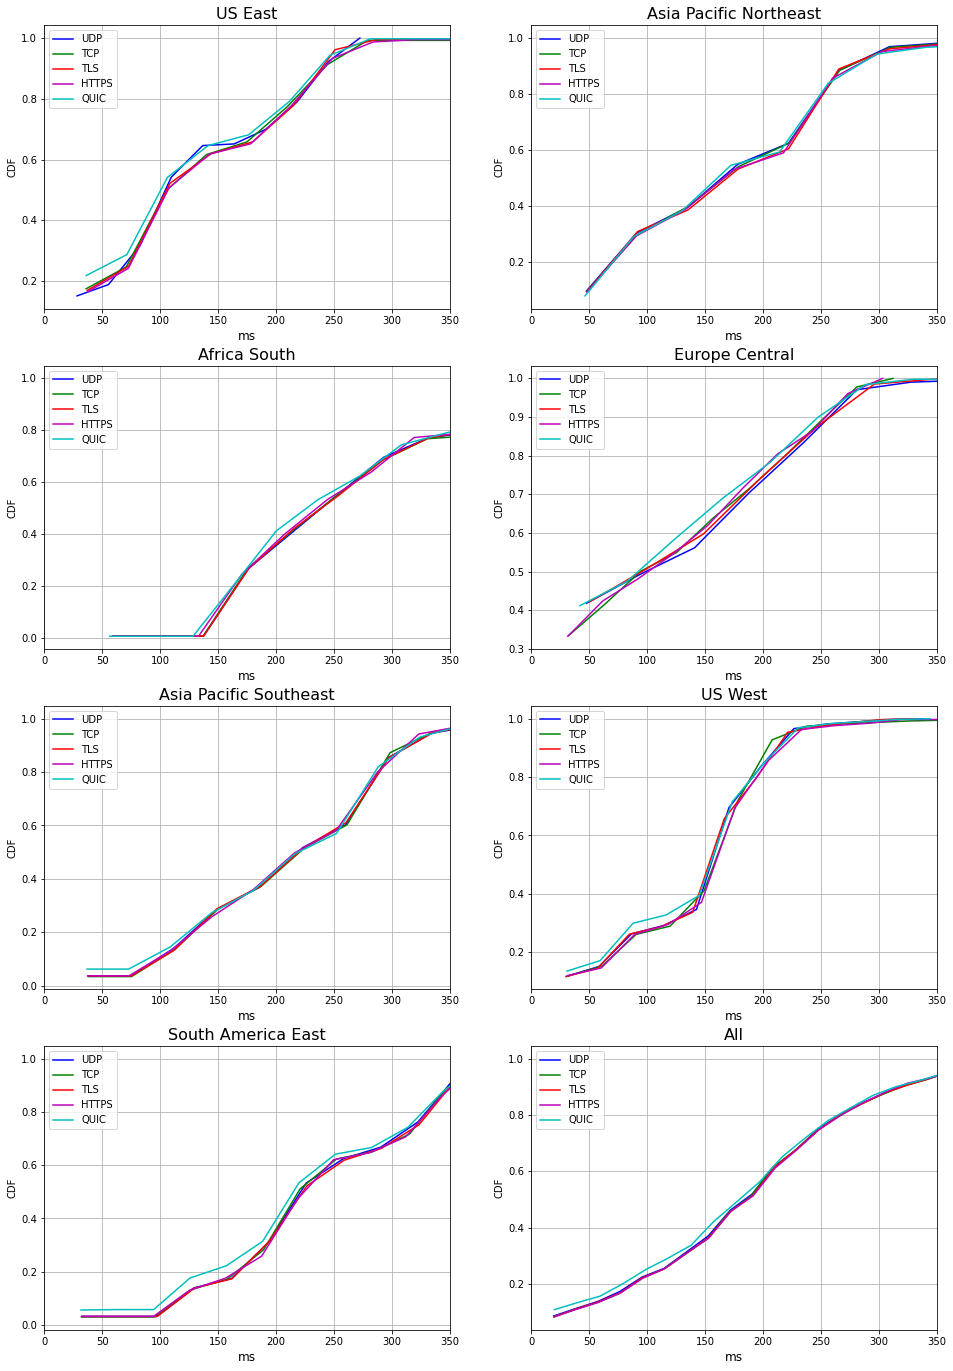

In [16]:
i = 0
fig, ax = plt.subplots(4, 2, figsize=(16, 24))

for key, vp in vantage_points.items():
    qt = vp['query_time']
    ax[int(i/2),i%2].plot(calculateCDF(qt['UDP'])[0], calculateCDF(qt['UDP'])[1], label="UDP", color = Colors.udp)
    ax[int(i/2),i%2].plot(calculateCDF(qt['TCP'])[0], calculateCDF(qt['TCP'])[1], label="TCP", color = Colors.tcp)
    ax[int(i/2),i%2].plot(calculateCDF(qt['TLS'])[0], calculateCDF(qt['TLS'])[1], label="TLS", color = Colors.tls)
    ax[int(i/2),i%2].plot(calculateCDF(qt['HTTPS'])[0], calculateCDF(qt['HTTPS'])[1], label="HTTPS", color = Colors.https)
    ax[int(i/2),i%2].plot(calculateCDF(qt['QUIC'])[0], calculateCDF(qt['QUIC'])[1], label="QUIC", color = Colors.quic)
    
    ax[int(i/2),i%2].set_xlim(0, 350)
    ax[int(i/2),i%2].set_xlabel("ms", fontsize = 12)
    ax[int(i/2),i%2].set_ylabel("CDF")
    ax[int(i/2),i%2].set_title(key, fontsize = 16)
    
    ax[int(i/2),i%2].legend()
    ax[int(i/2),i%2].grid()
    i += 1
    
plt.savefig("figures/resolve_time_cdf.pdf", bbox_inches='tight')
plt.show()

### Average resolve time

In [17]:
np.set_printoptions(precision=3)
for key, vp in vantage_points.items():
    vp['average_query_time'] = {
        'UDP': round(average(vp['UDP'], "query_time") / 1000000, 2),
        'TCP': round(average(vp['TCP'], "query_time") / 1000000, 2),
        'TLS': round(average(vp['TLS'], "query_time") / 1000000, 2),
        'HTTPS': round(average(vp['HTTPS'], "query_time") / 1000000, 2),
        'QUIC': round(average(vp['QUIC'], "query_time") / 1000000, 2)
    }
    print(key)
    print(vp['average_query_time'])

US East
{'UDP': 124.45, 'TCP': 132.74, 'TLS': 128.81, 'HTTPS': 131.92, 'QUIC': 123.27}
Asia Pacific Northeast
{'UDP': 168.93, 'TCP': 168.64, 'TLS': 170.18, 'HTTPS': 171.91, 'QUIC': 169.63}
Africa South
{'UDP': 257.63, 'TCP': 263.97, 'TLS': 255.18, 'HTTPS': 254.86, 'QUIC': 251.48}
Europe Central
{'UDP': 115.33, 'TCP': 113.43, 'TLS': 115.8, 'HTTPS': 112.96, 'QUIC': 106.28}
Asia Pacific Southeast
{'UDP': 212.55, 'TCP': 211.75, 'TLS': 212.39, 'HTTPS': 213.57, 'QUIC': 213.08}
US West
{'UDP': 137.72, 'TCP': 141.42, 'TLS': 138.95, 'HTTPS': 141.27, 'QUIC': 133.59}
South America East
{'UDP': 239.28, 'TCP': 237.62, 'TLS': 237.62, 'HTTPS': 236.6, 'QUIC': 231.37}
All
{'UDP': 183.61, 'TCP': 185.13, 'TLS': 183.66, 'HTTPS': 183.97, 'QUIC': 179.29}


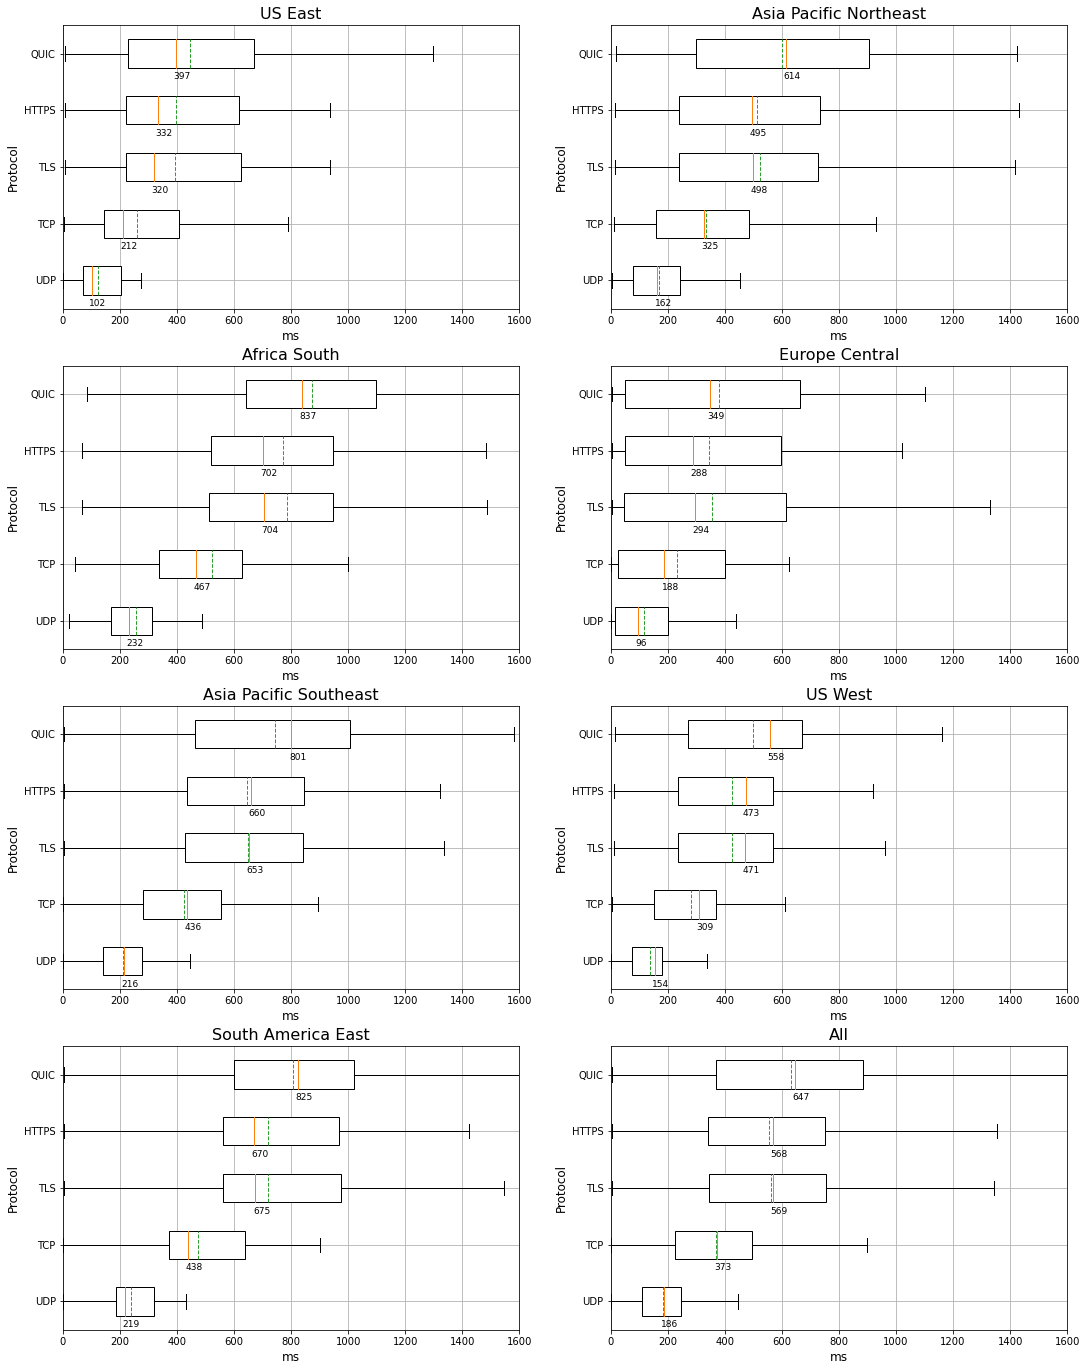

In [18]:
for key, vp in vantage_points.items():
    vp['total_time'] = {
    'UDP': list(map(lambda x: x["total_time"] / 1000000, vp['UDP'])),
    'TCP': list(map(lambda x: x["total_time"] / 1000000, vp['TCP'])),
    'TLS': list(map(lambda x: x["total_time"] / 1000000, vp['TLS'])),
    'HTTPS': list(map(lambda x: x["total_time"] / 1000000, vp['HTTPS'])),
    'QUIC': list(map(lambda x: x["total_time"] / 1000000, vp['QUIC']))
    }

i = 0
fig, ax = plt.subplots(4, 2, figsize=(18, 24))
for key, vp in vantage_points.items():
    tt = vp['total_time']
    bp = ax[int(i/2),i%2].boxplot([tt['UDP'], tt['TCP'], tt['TLS'], tt['HTTPS'], tt['QUIC']], vert = 0, sym = "", patch_artist=True, meanline = True, showmeans = True)
    setBoxesWhite(bp)

    for median in bp["medians"]:
        x, y = median.get_data()
        ax[int(i/2),i%2].text(x[0] - 9, y[0] - 0.2, "{:.0f}".format(x[0]), fontsize = 9, color='black')
    
    ax[int(i/2),i%2].set_xlim(0, 1600)
    ax[int(i/2),i%2].set_yticklabels(["UDP", "TCP", "TLS", "HTTPS", "QUIC"])
    ax[int(i/2),i%2].set_xlabel('ms', fontsize = 12)
    ax[int(i/2),i%2].set_ylabel("Protocol", fontsize = 12)
    ax[int(i/2),i%2].set_title(key, fontsize = 16)
    ax[int(i/2),i%2].grid()
    i += 1

plt.savefig("figures/total_time_boxplot.pdf", bbox_inches='tight')
plt.show()

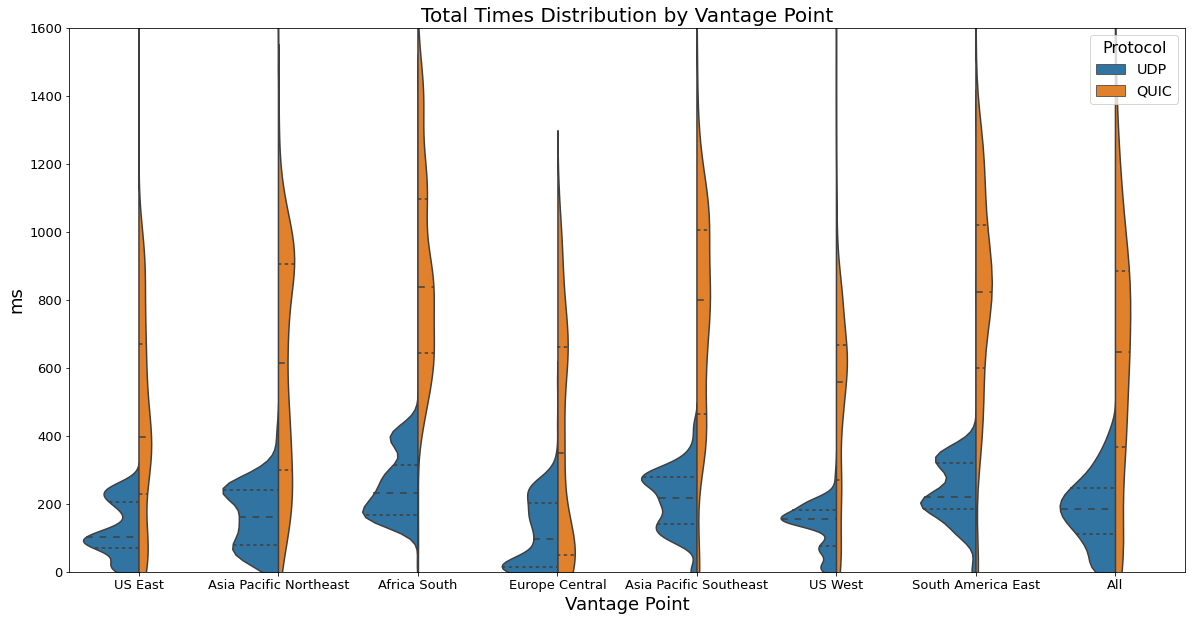

In [46]:
prot_1 = 'UDP'
prot_2 = 'QUIC'

fig, ax = plt.subplots(figsize=(20, 10))
x = []
y = []
z = []
for key, vp in vantage_points.items():
    ttu = vp['total_time'][prot_1]
    x.extend(len(ttu) * [key])
    y.extend(ttu)
    z.extend(len(ttu) * [prot_1])
    
    ttq = vp['total_time'][prot_2]
    x.extend(len(ttq) * [key])
    y.extend(ttq)
    z.extend(len(ttq) * [prot_2])
    
data = pd.DataFrame(dict(x=x, y=y, z=z))

ax.set_title('Total Times Distribution by Vantage Point', fontsize = 20)
ax.set_ylim(0, 1600)

v = sns.violinplot(data=data, x='x', y='y',
               split=True, hue = 'z',
               ax = ax, inner='quartile',
               bw = 0.3)
v.set_xlabel('Vantage Point', fontsize = 18)
v.set_ylabel('ms', fontsize = 18)
v.tick_params(labelsize=13)

plt.legend(title='Protocol', fontsize='x-large', title_fontsize='16')
plt.savefig("figures/total_time_violinplot.pdf", bbox_inches='tight')
plt.show()

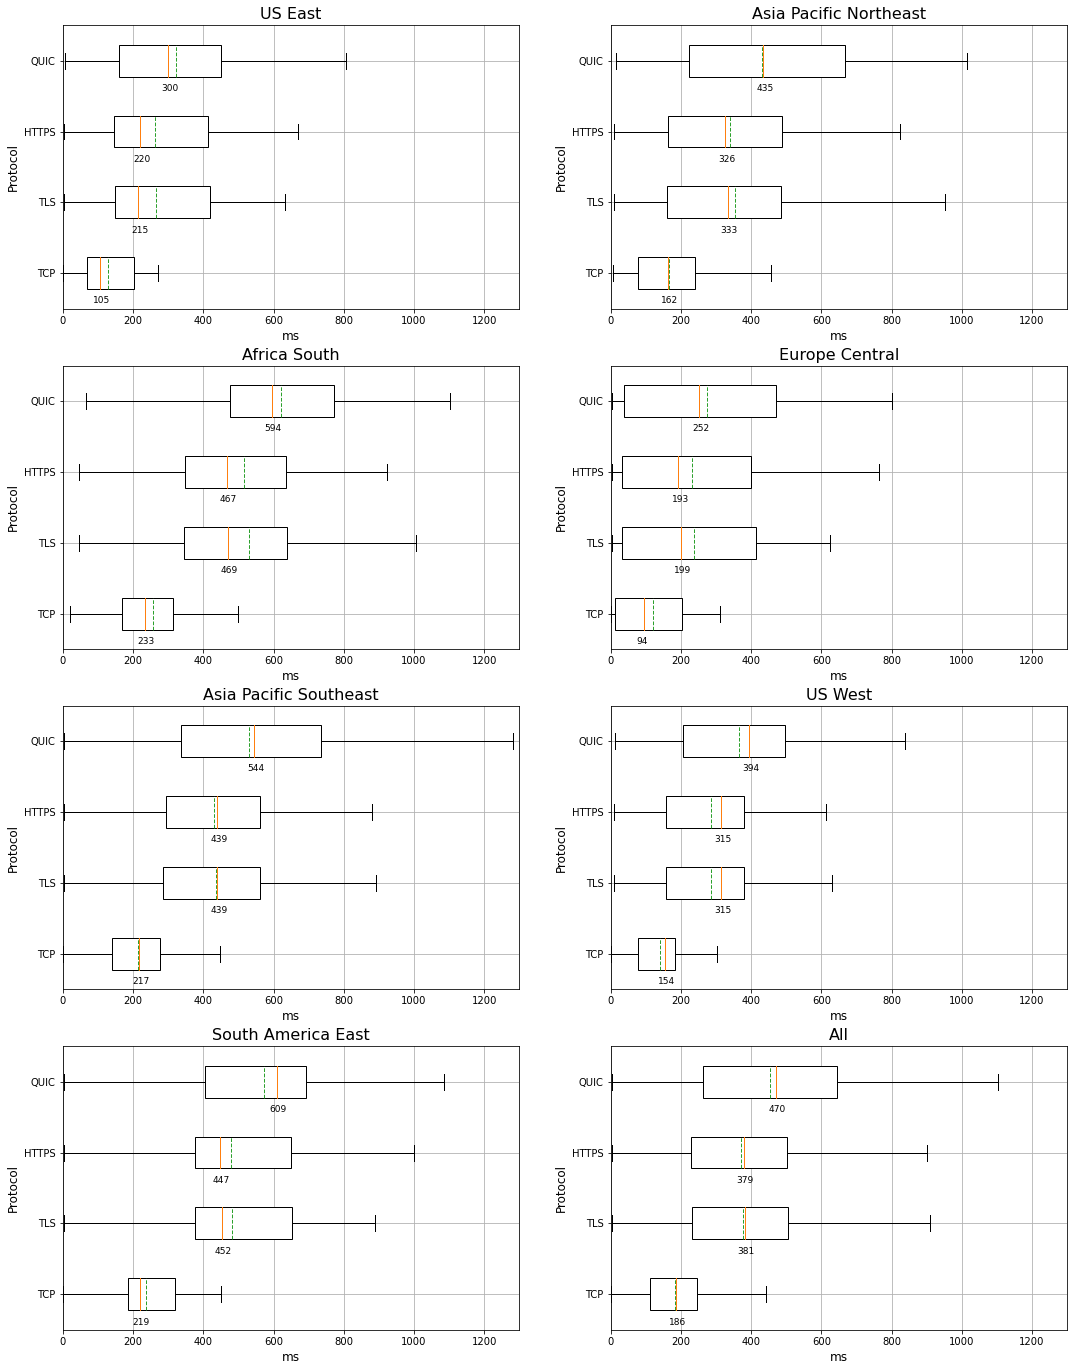

In [16]:
for key, vp in vantage_points.items():
    vp['setup_time'] = {
    'UDP': list(map(lambda x: x["udp_socket_setup_duration"] / 1000000, vp['UDP'])),
    'TCP': list(map(lambda x: x["tcp_handshake_duration"] / 1000000, vp['TCP'])),
    'TLS': list(map(lambda x: (x["tcp_handshake_duration"] + x["tls_handshake_duration"]) / 1000000, vp['TLS'])),
    'HTTPS': list(map(lambda x: (x["tcp_handshake_duration"] + x["tls_handshake_duration"]) / 1000000, vp['HTTPS'])),
    'QUIC': list(map(lambda x: x["q_ui_c_handshake_duration"] / 1000000, vp['QUIC']))
    }

    
i = 0
fig, ax = plt.subplots(4, 2, figsize=(18, 24))
for key, vp in vantage_points.items():
    st = vp['setup_time']
    bp = ax[int(i/2),i%2].boxplot([st['TCP'], st['TLS'], st['HTTPS'], st['QUIC']], vert = 0, showfliers = False, patch_artist=True, meanline = True, showmeans = True)
    setBoxesWhite(bp)

    for median in bp["medians"]:
        x, y = median.get_data()
        ax[int(i/2),i%2].text(x[0] - 20, y[0] - 0.2, "{:.0f}".format(x[0]), fontsize = 9, color='black')

    ax[int(i/2),i%2].set_xlim(0, 1300)
    ax[int(i/2),i%2].set_yticklabels(["TCP", "TLS", "HTTPS", "QUIC"])
    ax[int(i/2),i%2].set_xlabel("ms", fontsize = 12)
    ax[int(i/2),i%2].set_ylabel("Protocol", fontsize = 12)
    ax[int(i/2),i%2].set_title(key, fontsize = 16)
    ax[int(i/2),i%2].grid()
    i += 1


plt.savefig("figures/handshake_time_boxplot.pdf", bbox_inches='tight')
plt.show(bp)

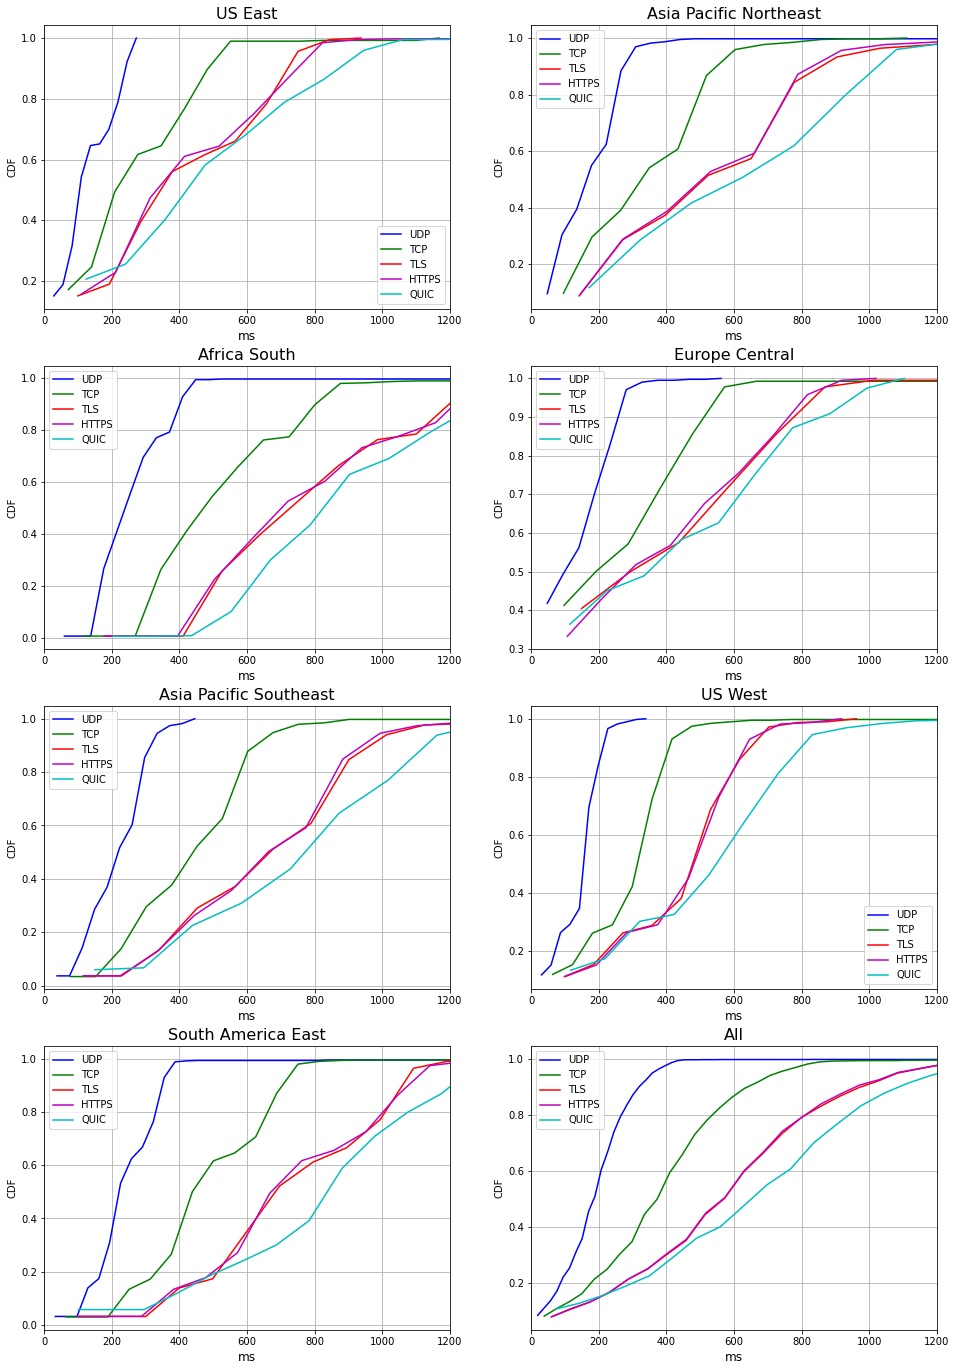

In [17]:
i = 0
fig, ax = plt.subplots(4, 2, figsize=(16, 24))

for key, vp in vantage_points.items():
    tt = vp['total_time']
    ax[int(i/2),i%2].plot(calculateCDF(tt['UDP'])[0], calculateCDF(tt['UDP'])[1], label="UDP", color = Colors.udp)
    ax[int(i/2),i%2].plot(calculateCDF(tt['TCP'])[0], calculateCDF(tt['TCP'])[1], label="TCP", color = Colors.tcp)
    ax[int(i/2),i%2].plot(calculateCDF(tt['TLS'])[0], calculateCDF(tt['TLS'])[1], label="TLS", color = Colors.tls)
    ax[int(i/2),i%2].plot(calculateCDF(tt['HTTPS'])[0], calculateCDF(tt['HTTPS'])[1], label="HTTPS", color = Colors.https)
    ax[int(i/2),i%2].plot(calculateCDF(tt['QUIC'])[0], calculateCDF(tt['QUIC'])[1], label="QUIC", color = Colors.quic)
    
    ax[int(i/2),i%2].set_xlim(0, 1200)
    ax[int(i/2),i%2].set_xlabel("ms", fontsize = 12)
    ax[int(i/2),i%2].set_ylabel("CDF")
    ax[int(i/2),i%2].set_title(key, fontsize = 16)
    
    ax[int(i/2),i%2].legend()
    ax[int(i/2),i%2].grid()
    i += 1
    
plt.savefig("figures/total_time_cdf.pdf", bbox_inches='tight')
plt.show()

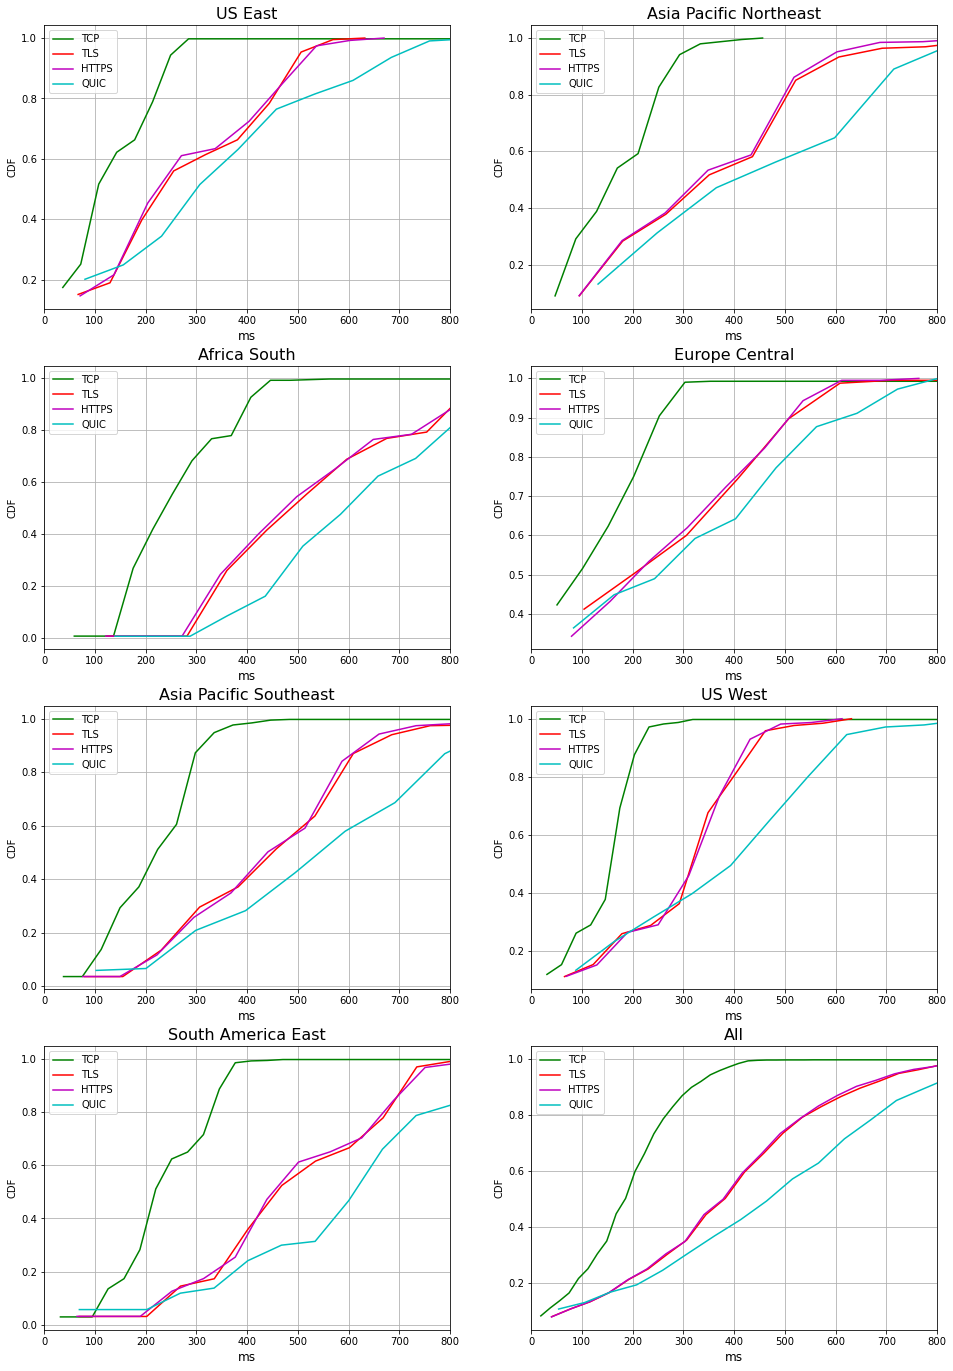

In [18]:
i = 0
fig, ax = plt.subplots(4, 2, figsize=(16, 24))

for key, vp in vantage_points.items():
    st = vp['setup_time']
    #ax[int(i/2),i%2].plot(calculateCDF(st['UDP'])[0], calculateCDF(st['UDP'])[1], label="UDP", color = Colors.udp)
    ax[int(i/2),i%2].plot(calculateCDF(st['TCP'])[0], calculateCDF(st['TCP'])[1], label="TCP", color = Colors.tcp)
    ax[int(i/2),i%2].plot(calculateCDF(st['TLS'])[0], calculateCDF(st['TLS'])[1], label="TLS", color = Colors.tls)
    ax[int(i/2),i%2].plot(calculateCDF(st['HTTPS'])[0], calculateCDF(st['HTTPS'])[1], label="HTTPS", color = Colors.https)
    ax[int(i/2),i%2].plot(calculateCDF(st['QUIC'])[0], calculateCDF(st['QUIC'])[1], label="QUIC", color = Colors.quic)
    
    ax[int(i/2),i%2].set_xlim(0, 800)
    ax[int(i/2),i%2].set_xlabel("ms", fontsize = 12)
    ax[int(i/2),i%2].set_ylabel("CDF")
    ax[int(i/2),i%2].set_title(key, fontsize = 16)
    
    ax[int(i/2),i%2].legend()
    ax[int(i/2),i%2].grid()
    i += 1
    
plt.savefig("figures/setup_time_cdf.pdf", bbox_inches='tight')
plt.show()

### Traceroutes per Protocol

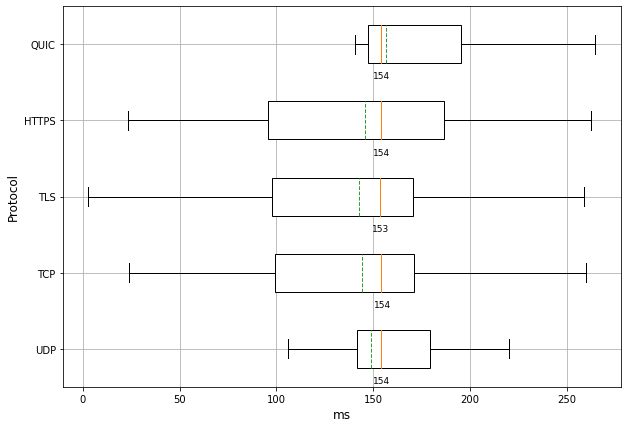

In [5]:
getMeanTraceroutes()

### QUIC Handshake Duration / RTT

In [17]:
times = getQUICMedianTraceroutes()
times["handshake/rtt"] = times.apply(lambda row: row["quic_handshake_duration"]/row["rtt"], axis = 1)
times["resolve-rtt"] = times.apply(lambda row: (row["query_time"] - row["rtt"]) / 1000000, axis = 1)

In [18]:
times_uncached = getQUICMedianTraceroutes(cacheWarming = True)
times_uncached["resolve-rtt"] = times_uncached.apply(lambda row: (row["query_time"] - row["rtt"]) / 1000000, axis = 1)

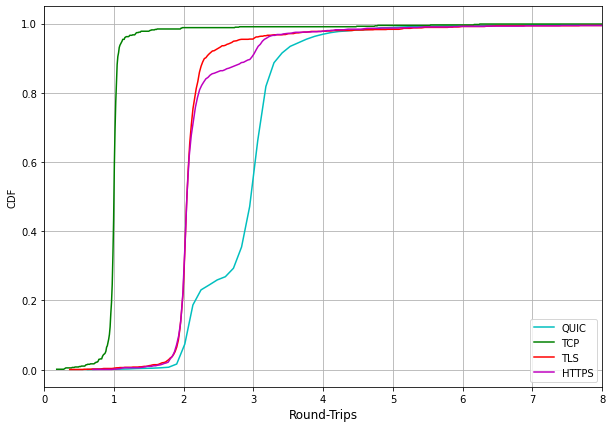

In [19]:
def plotHandshake():
    def filterNA(df):
        return df[df["handshake/rtt"].notna()]["handshake/rtt"].tolist()
    
    def addTLS(row):
        if row["tcp_handshake_duration"] and row["tls_handshake_duration"]:
            return (row["tcp_handshake_duration"] + row["tls_handshake_duration"])/row["rtt"]
        return np.nan
    
    quicTimes = getQUICMedianTraceroutes(protocol = "quic")
    tcpTimes = getQUICMedianTraceroutes(protocol = "tcp")
    tlsTimes = getQUICMedianTraceroutes(protocol = "tls")
    httpsTimes = getQUICMedianTraceroutes(protocol = "https")
    quicTimes["handshake/rtt"] = quicTimes.apply(lambda row: row["quic_handshake_duration"]/row["rtt"], axis = 1)
    tcpTimes["handshake/rtt"] = tcpTimes.apply(lambda row: row["tcp_handshake_duration"]/row["rtt"], axis = 1)
    tlsTimes["handshake/rtt"] = tlsTimes.apply(addTLS, axis = 1)
    httpsTimes["handshake/rtt"] = httpsTimes.apply(addTLS, axis = 1)
    
    fig = plt.figure(figsize = (10, 7))
    
    distQUIC = filterNA(quicTimes)
    distTCP = filterNA(tcpTimes)
    distTLS = filterNA(tlsTimes)
    distHTTPS = filterNA(httpsTimes)
    
    plt.plot(calculateCDF(distQUIC)[0], calculateCDF(distQUIC)[1], label="QUIC", color = Colors.quic)
    plt.plot(calculateCDF(distTCP)[0], calculateCDF(distTCP)[1], label="TCP", color = Colors.tcp)
    plt.plot(calculateCDF(distTLS)[0], calculateCDF(distTLS)[1], label="TLS", color = Colors.tls)
    plt.plot(calculateCDF(distHTTPS)[0], calculateCDF(distHTTPS)[1], label="HTTPS", color = Colors.https)
    
    plt.xlim([0, 8])
    plt.grid()
    plt.legend()
    plt.xlabel("Round-Trips", fontsize = 12)
    plt.ylabel("CDF")
    
    plt.savefig("figures/handshake-rtt.pdf", bbox_inches='tight')
    plt.show()
    

plotHandshake()

In [20]:
def getQLogPandas():
    items = []
    with open("qlog-results.json", "r") as f:
        result = json.load(f)
    for ip, ports in result.items():
        for port, stats in ports.items():
            items.append({ "ip": ip, "port": int(port), "success": stats["success"], "retry": stats["retry"], "version_negotiation": stats["version_negotiation"] })
            
    return pd.DataFrame(items)

qlogResult = getQLogPandas()

In [21]:
quicTimes = getQUICMedianTraceroutes(protocol = "quic")

In [22]:
combined = pd.merge(quicTimes, qlogResult, on = ["ip", "port"])

In [23]:
def normalized(row):
    duration = row["quic_handshake_duration"]
    if not row["success"]:
        return duration / row["rtt"]
    if row["retry"]:
        duration -= row["rtt"]
    if row["version_negotiation"]:
        duration -= row["rtt"]
    return duration / row["rtt"]

combined["handshake/rtt"] = combined.apply(lambda row: row["quic_handshake_duration"]/row["rtt"], axis = 1)
combined["n(handshake/rtt)"] = combined.apply(normalized, axis = 1)

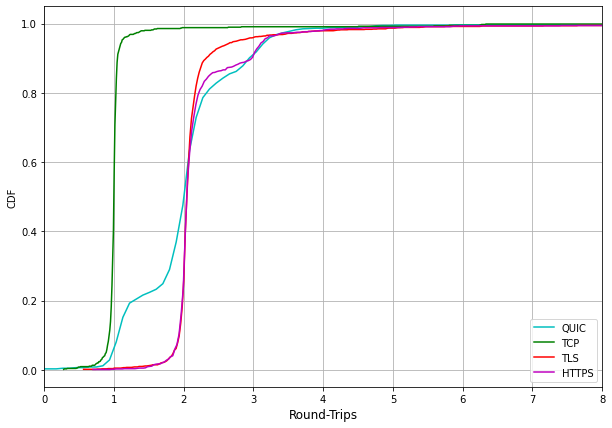

In [24]:
def plotHandshakeNormalized():
    def normalized(row):
        duration = row["quic_handshake_duration"]
        if not row["success"]:
            return duration / row["rtt"]
        if row["retry"]:
            duration -= row["rtt"]
        if row["version_negotiation"]:
            duration -= row["rtt"]
        return duration / row["rtt"]
    
    def filterNA(df):
        return df[df["handshake/rtt"].notna()]["handshake/rtt"].tolist()
    
    def addTLS(row):
        if row["tcp_handshake_duration"] and row["tls_handshake_duration"]:
            return (row["tcp_handshake_duration"] + row["tls_handshake_duration"])/row["rtt"]
        return np.nan
    
    quicTimes = getQUICMedianTraceroutes(protocol = "quic")
    combined = pd.merge(quicTimes, qlogResult, on = ["ip", "port"])
    combined["n(handshake/rtt)"] = combined.apply(normalized, axis = 1)
    tcpTimes = getQUICMedianTraceroutes(protocol = "tcp")
    tlsTimes = getQUICMedianTraceroutes(protocol = "tls")
    httpsTimes = getQUICMedianTraceroutes(protocol = "https")
    quicTimes["handshake/rtt"] = quicTimes.apply(lambda row: row["quic_handshake_duration"]/row["rtt"], axis = 1)
    tcpTimes["handshake/rtt"] = tcpTimes.apply(lambda row: row["tcp_handshake_duration"]/row["rtt"], axis = 1)
    tlsTimes["handshake/rtt"] = tlsTimes.apply(addTLS, axis = 1)
    httpsTimes["handshake/rtt"] = httpsTimes.apply(addTLS, axis = 1)
    
    fig = plt.figure(figsize = (10, 7))
    
    distQUIC = combined[combined["n(handshake/rtt)"].notna()]["n(handshake/rtt)"].tolist()
    distTCP = filterNA(tcpTimes)
    distTLS = filterNA(tlsTimes)
    distHTTPS = filterNA(httpsTimes)
    
    plt.plot(calculateCDF(distQUIC)[0], calculateCDF(distQUIC)[1], label="QUIC", color = Colors.quic)
    plt.plot(calculateCDF(distTCP)[0], calculateCDF(distTCP)[1], label="TCP", color = Colors.tcp)
    plt.plot(calculateCDF(distTLS)[0], calculateCDF(distTLS)[1], label="TLS", color = Colors.tls)
    plt.plot(calculateCDF(distHTTPS)[0], calculateCDF(distHTTPS)[1], label="HTTPS", color = Colors.https)
    
    plt.xlim([0, 8])
    plt.grid()
    plt.legend()
    plt.xlabel("Round-Trips", fontsize = 12)
    plt.ylabel("CDF")
    
    plt.savefig("figures/handshake-rtt-normalized.pdf", bbox_inches='tight')
    plt.show()
    

plotHandshakeNormalized()

In [25]:
def normalized(row):
    duration = row["quic_handshake_duration"]
    if not row["success"]:
        return duration / row["rtt"]
    if row["retry"]:
        duration -= row["rtt"]
    if row["version_negotiation"]:
        duration -= row["rtt"]
    return duration

quicTimes = getQUICMedianTraceroutes(protocol = "quic")
combined = pd.merge(quicTimes, qlogResult, on = ["ip", "port"])
tcpTimes = getQUICMedianTraceroutes(protocol = "tcp")
tlsTimes = getQUICMedianTraceroutes(protocol = "tls")
httpsTimes = getQUICMedianTraceroutes(protocol = "https")
udpTimes = getQUICMedianTraceroutes(protocol = "udp")

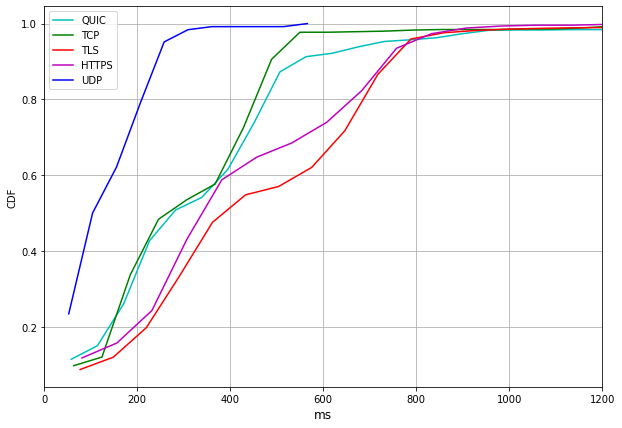

In [26]:
combined["n(handshake)"] = combined.apply(normalized, axis = 1)
combined["n(total_time)"] = combined["total_time"] - combined["n(handshake)"]

fig = plt.figure(figsize = (10, 7))

distUDP = udpTimes[udpTimes["total_time"].notna()]["total_time"].div(1000000).tolist()
distQUIC = combined[combined["n(total_time)"].notna()]["n(total_time)"].div(1000000).tolist()
distTCP = tcpTimes[tcpTimes["total_time"].notna()]["total_time"].div(1000000).tolist()
distTLS = tlsTimes[tlsTimes["total_time"].notna()]["total_time"].div(1000000).tolist()
distHTTPS = httpsTimes[httpsTimes["total_time"].notna()]["total_time"].div(1000000).tolist()

plt.plot(calculateCDF(distQUIC)[0], calculateCDF(distQUIC)[1], label="QUIC", color = Colors.quic)
plt.plot(calculateCDF(distTCP)[0], calculateCDF(distTCP)[1], label="TCP", color = Colors.tcp)
plt.plot(calculateCDF(distTLS)[0], calculateCDF(distTLS)[1], label="TLS", color = Colors.tls)
plt.plot(calculateCDF(distHTTPS)[0], calculateCDF(distHTTPS)[1], label="HTTPS", color = Colors.https)
plt.plot(calculateCDF(distUDP)[0], calculateCDF(distUDP)[1], label="UDP", color = Colors.udp)

plt.grid()
plt.legend()
plt.xlabel("ms", fontsize = 12)
plt.ylabel("CDF")
plt.xlim([0, 1200])

plt.savefig("figures/total_time_normalized_cdf.pdf", bbox_inches='tight')
plt.show()

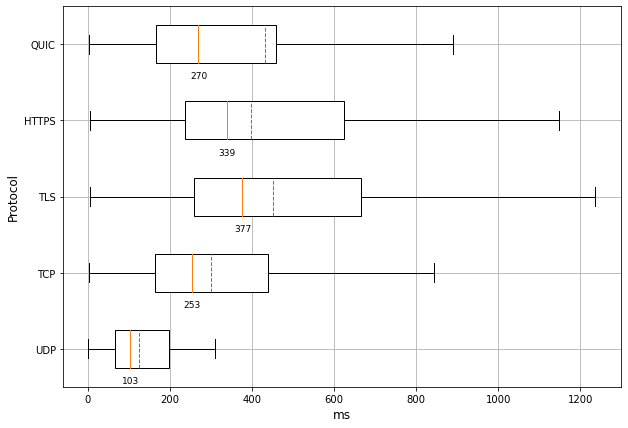

In [27]:
combined["n(handshake)"] = combined.apply(normalized, axis = 1)
combined["n(total_time)"] = combined["total_time"] - combined["n(handshake)"]

distQUIC = combined[combined["n(total_time)"].notna()]["n(total_time)"].div(1000000).tolist()
distTCP = tcpTimes[tcpTimes["total_time"].notna()]["total_time"].div(1000000).tolist()
distTLS = tlsTimes[tlsTimes["total_time"].notna()]["total_time"].div(1000000).tolist()
distHTTPS = httpsTimes[httpsTimes["total_time"].notna()]["total_time"].div(1000000).tolist()
distUDP = udpTimes[udpTimes["total_time"].notna()]["total_time"].div(1000000).tolist()

fig = plt.figure(figsize = (10, 7))
ax = fig.add_subplot(111)
bp = ax.boxplot([distUDP, distTCP, distTLS, distHTTPS, distQUIC], vert = 0, showfliers = False, patch_artist=True, meanline = True, showmeans = True)
setBoxesWhite(bp)

for median in bp["medians"]:
    x, y = median.get_data()
    ax.text(x[0] - 20, y[0] - 0.2, "{:.0f}".format(x[0]), fontsize = 9, color='black')

ax.set_yticklabels(["UDP", "TCP", "TLS", "HTTPS", "QUIC"])

ax.set_xlabel("ms", fontsize = 12)
ax.set_ylabel("Protocol", fontsize = 12)
plt.grid()

plt.savefig("figures/total_time_normalized_boxplot.pdf", bbox_inches='tight')
plt.show(bp)

## Smallest Variance

In [28]:
def getSetupTime():
    def generateStatement(protocol):
        return "SELECT ip FROM dns_measurements {} WHERE {}.protocol = '{}' AND {}.response_ip IS NOT NULL AND NOT {}.cache_warming".format(protocol, protocol, protocol, protocol, protocol)
    statements = {
        "udp": generateStatement("udp"),
        "tcp": generateStatement("tcp"),
        "tls": generateStatement("tls"),
        "https": generateStatement("https"),
        "quic": generateStatement("quic")
    }
    sql = """
    SELECT ip, protocol, q_ui_c_handshake_duration / 1000000 as quic_handshake_duration, tcp_handshake_duration / 1000000 as tcp_handshake_duration, tls_handshake_duration / 1000000 as tls_handshake_duration, port FROM dns_measurements measurement
    WHERE measurement.r_code IS NOT NULL AND measurement.total_time IS NOT NULL AND measurement.total_time <= 5000000000
      AND NOT measurement.cache_warming
      AND measurement.ip IN ({})
      AND measurement.ip IN ({})
      AND measurement.ip IN ({})
      AND measurement.ip IN ({})
      AND measurement.ip IN ({})
    """.format(*statements.values())
    df = pd.read_sql_query(sql, connection)
    return df

setupTime = getSetupTime()
setupTime["tls_total"] = setupTime.apply(lambda row: row["tcp_handshake_duration"] + row["tls_handshake_duration"] if row["protocol"] == "tls" or row["protocol"] == "https" else None, axis = 1)

In [29]:
smallestVar = setupTime.groupby("ip")["quic_handshake_duration"].var().reset_index(name = "var").nsmallest(50, "var")
largestVar = setupTime.groupby("ip")["quic_handshake_duration"].var().reset_index(name = "var").nlargest(50, "var")

In [30]:
records = pd.DataFrame([*udp, *tcp, *tls, *https, *quic], columns = udp[0].keys())

In [31]:
smallestRecords = records[records["ip"].isin(smallestVar["ip"].unique())]
smallestRecords["tls_total"] = smallestRecords.apply(lambda row: row["tcp_handshake_duration"] + row["tls_handshake_duration"] if row["protocol"] == "tls" or row["protocol"] == "https" else None, axis = 1)
largestRecords = records[records["ip"].isin(largestVar["ip"].unique())]
largestRecords["tls_total"] = largestRecords.apply(lambda row: row["tcp_handshake_duration"] + row["tls_handshake_duration"] if row["protocol"] == "tls" or row["protocol"] == "https" else None, axis = 1)

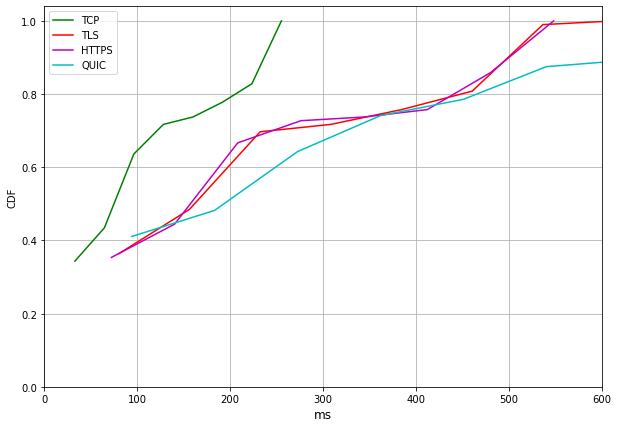

In [32]:
fig = plt.figure(figsize = (10, 7))
tcpCDF = calculateCDF(smallestRecords[smallestRecords["protocol"] == "tcp"]["tcp_handshake_duration"].div(1000000).tolist())
tlsCDF = calculateCDF(smallestRecords[smallestRecords["protocol"] == "tls"]["tls_total"].div(1000000).tolist())
httpsCDF = calculateCDF(smallestRecords[smallestRecords["protocol"] == "https"]["tls_total"].div(1000000).tolist())
quicCDF = calculateCDF(smallestRecords[smallestRecords["protocol"] == "quic"]["q_ui_c_handshake_duration"].div(1000000).tolist())

plt.plot(tcpCDF[0], tcpCDF[1], label="TCP", color = Colors.tcp)
plt.plot(tlsCDF[0], tlsCDF[1], label="TLS", color = Colors.tls)
plt.plot(httpsCDF[0], httpsCDF[1], label="HTTPS", color = Colors.https)
plt.plot(quicCDF[0], quicCDF[1], label="QUIC", color = Colors.quic)
plt.xlim([0, 600])
plt.ylim([0, 1.04])

plt.xlabel("ms", fontsize = 12)
plt.ylabel("CDF")

plt.legend()
plt.grid()

plt.savefig("figures/setup_time_low_variance_pdf.pdf", bbox_inches='tight')

plt.show()

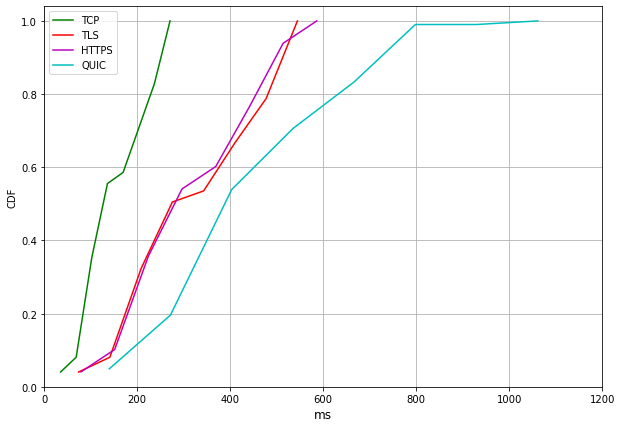

In [33]:
fig = plt.figure(figsize = (10, 7))
tcpCDF = calculateCDF(largestRecords[largestRecords["protocol"] == "tcp"]["tcp_handshake_duration"].div(1000000).tolist())
tlsCDF = calculateCDF(largestRecords[largestRecords["protocol"] == "tls"]["tls_total"].div(1000000).tolist())
httpsCDF = calculateCDF(largestRecords[largestRecords["protocol"] == "https"]["tls_total"].div(1000000).tolist())
quicCDF = calculateCDF(largestRecords[largestRecords["protocol"] == "quic"]["q_ui_c_handshake_duration"].div(1000000).tolist())

plt.plot(tcpCDF[0], tcpCDF[1], label="TCP", color = Colors.tcp)
plt.plot(tlsCDF[0], tlsCDF[1], label="TLS", color = Colors.tls)
plt.plot(httpsCDF[0], httpsCDF[1], label="HTTPS", color = Colors.https)
plt.plot(quicCDF[0], quicCDF[1], label="QUIC", color = Colors.quic)
plt.xlim([0, 1200])
plt.ylim([0, 1.04])

plt.xlabel("ms", fontsize = 12)
plt.ylabel("CDF")

plt.legend()
plt.grid()

plt.savefig("figures/setup_time_high_variance_pdf.pdf", bbox_inches='tight')

plt.show()